# Урок 1. Основы обучения нейронных сетей

### Задание. 
**Попробуйте видоизменить параметры разобранной на уроке двухслойной нейронной сети таким образом, чтобы улучшить ее точность. Проведите анализ — что приводит к ухудшению точности нейронной сети? Что приводит к увеличению ее точности?**

In [1]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

**Шаг 1. Определение функций, которые понадобяться для обучения  
преобразование массива в бинарный вид результатов**

In [2]:
def to_one_hot(Y):
    n_col = np.amax(Y) + 1
    binarized = np.zeros((len(Y), n_col))
    for i in range(len(Y)):
        binarized[i, Y[i]] = 1.
    return binarized

# преобразование массива в необходимый вид
def from_one_hot(Y):
    arr = np.zeros((len(Y), 1))

    for i in range(len(Y)):
        l = layer2[i]
        for j in range(len(l)):
            if(l[j] == 1):
                arr[i] = j+1
    return arr

# сигмоида и ее производная
def sigmoid(x):
    return 1/(1+np.exp(-x))

def sigmoid_deriv(x):
    return sigmoid(x)*(1 - sigmoid(x))

# нормализация массива
def normalize(X, axis=-1, order=2):
    l2 = np.atleast_1d(np.linalg.norm(X, order, axis))
    l2[l2 == 0] = 1
    return X / np.expand_dims(l2, axis)

**Шаг 2. Подготовка тренировочных данных  
получения данных из csv файла. укажите здесь путь к файлу Iris.csv**

In [3]:
iris_data = pd.read_csv("Iris.csv")

# репрезентация данных в виде графиков
# g = sns.pairplot(iris_data.drop("Id", axis=1), hue="Species")

# замена текстовых значений на цифровые
iris_data['Species'].replace(['Iris-setosa', 'Iris-virginica', 'Iris-versicolor'], [0, 1, 2], inplace=True)

# формирование входных данных
columns = ['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']
x = pd.DataFrame(iris_data, columns=columns)
x = normalize(x.values)

# формирование выходных данных(результатов)
columns = ['Species']
y = pd.DataFrame(iris_data, columns=columns)
y = y.values
y = y.flatten()
y = to_one_hot(y)

# # Разделение данных на тренировочные и тестовые
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33)

**Шаг 3. Обученние нейронной сети  
присваевание случайных весов**

In [4]:
def train_network(neuron_numb, step, iterations):
    
    start = time.time()    
            
    w0 = 2*np.random.random((4, neuron_numb)) - 1 
    w1 = 2*np.random.random((neuron_numb, 3)) - 1

    for i in range(iterations):

        # прямое распространение(feed forward)
        layer0 = X_train
        layer1 = sigmoid(np.dot(layer0, w0))
        layer2 = sigmoid(np.dot(layer1, w1))

        # обратное распространение(back propagation) с использованием градиентного спуска
        layer2_error = y_train - layer2
        layer2_delta = layer2_error * sigmoid_deriv(layer2)

        layer1_error = layer2_delta.dot(w1.T)
        layer1_delta = layer1_error * sigmoid_deriv(layer1)

        w1 += layer1.T.dot(layer2_delta) * step
        w0 += layer0.T.dot(layer1_delta) * step

        error = np.mean(np.abs(layer2_error))
        accuracy = (1 - error) * 100
        
    end = time.time()
    
    return end - start, accuracy

In [5]:
# hyperparameters
steps = [0.8, 0.6, 0.4, 0.2, 0.1, 0.05, 0.01]
iterations = [100, 500, 1000, 1500, 2000, 3000, 5000]
neurons = [2, 3, 4, 5, 6, 7, 8, 9, 10]

default_step, default_iterations, default_neurons = 0.1, 1000, 5

stages_stats = pd.DataFrame(columns=['stage', 'neuron number','learning rate', 'iteration number', 'train time', 'accuracy'])

stats = stages_stats.drop('stage', axis=1)

**Процесс обучения по стадиям**

In [6]:
%%time

count = 0

# 0 - увеличение количества нейронов в скрытом слое
stage = 0
for n in neurons: 
    
    train_time, accuracy = train_network(n, default_step, default_iterations)
    
    stages_stats.loc[count] = stage, n, default_step, default_iterations, train_time, accuracy
        
    count += 1
    
# 1 - увеличение скорости обучения
stage = 1
for s in steps: 
    
    train_time, accuracy = train_network(default_neurons, s, default_iterations)
    
    stages_stats.loc[count] = stage, default_neurons, s, default_iterations, train_time, accuracy
        
    count += 1
    
# 2 - увеличение количества итераций
stage = 2
for i in iterations: 
    
    train_time, accuracy = train_network(default_neurons, default_step, i)
    
    stages_stats.loc[count] = stage, default_neurons, default_step, i, train_time, accuracy
        
    count += 1

Wall time: 4.02 s


**Процесс обучения с перебором всех гиперпараметров**

In [7]:
%%time

count = 0

for n in neurons: 
    for s in steps: 
        for i in iterations:               
            
            train_time, accuracy = train_network(n, s, i)            

            stats.loc[count] = n, s, i, train_time, accuracy

            count += 1

Wall time: 1min 59s


**Шаг 4. Демонстрация полученных результатов  
черчение диаграммы точности в зависимости от обучения**

In [8]:
# для более аккуратного отображения
for col in stages_stats.columns:            
    if col == 'stage':        
        stages_stats[col] = stages_stats[col].astype(int)
    elif col == 'neuron number' or col == 'iteration number':
        stages_stats[col] = stages_stats[col].astype(int)
        stats[col] = stats[col].astype(int)

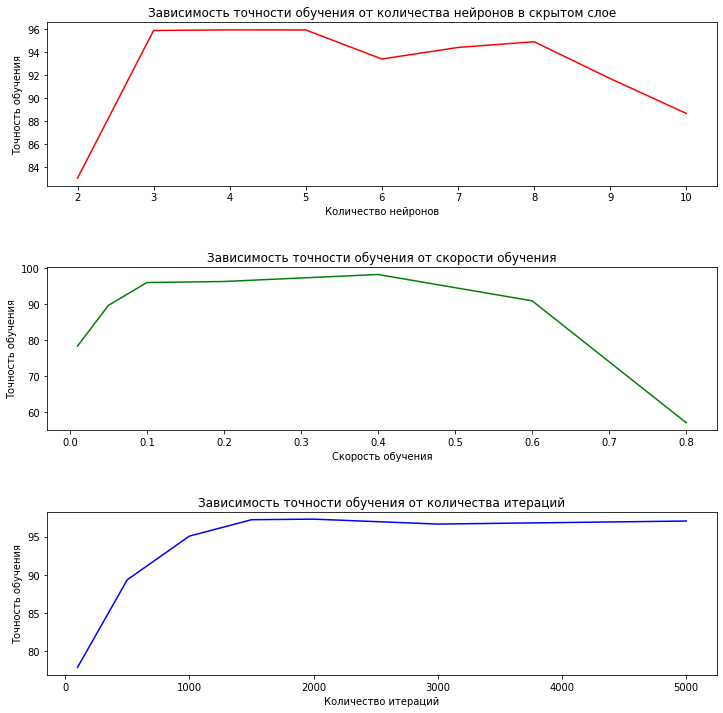

In [10]:
fig, (stage_0, stage_1, stage_2) = plt.subplots(nrows=3, figsize=(12, 12))
# fig.tight_layout(pad=5.0)
fig.subplots_adjust(hspace=0.5)

stage_0.set_title('Зависимость точности обучения от количества нейронов в скрытом слое')
stage_0.set(xlabel='Количество нейронов', ylabel='Точность обучения')
stage_0.plot(neurons, stages_stats.loc[stages_stats['stage'] == 0]['accuracy'], 'r')

stage_1.set_title('Зависимость точности обучения от скорости обучения')
stage_1.set(xlabel='Скорость обучения', ylabel='Точность обучения')
stage_1.plot(steps, stages_stats.loc[stages_stats['stage'] == 1]['accuracy'], 'g')

stage_2.set_title('Зависимость точности обучения от количества итераций')
stage_2.set(xlabel='Количество итераций', ylabel='Точность обучения')
stage_2.plot(iterations, stages_stats.loc[stages_stats['stage'] == 2]['accuracy'], 'b')

plt.show()

In [9]:
# выведем 10 лучших результатов
stats.sort_values(by='accuracy', ascending=False).head(10).round(3)

,neuron number,learning rate,iteration number,train time,accuracy
209,6,0.6,5000,0.769,99.904
256,7,0.6,2000,0.282,99.823
152,5,0.8,3000,0.410,99.782
118,4,0.4,5000,0.617,99.661
347,9,0.8,2000,0.294,99.556
125,4,0.2,5000,0.616,99.544
116,4,0.4,2000,0.247,99.531
76,3,0.2,5000,0.602,99.503
67,3,0.4,2000,0.239,99.477
353,9,0.6,1500,0.218,99.471
